In [1]:
import torch
from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import Parameter
import matplotlib.pyplot as plt
from svetlanna import wavefront as w
from svetlanna.units import ureg

# Использование пространственного модулятора света(SLM)

Пространственный модулятор света (SLM) позволяет управлять фазовым распределением падающего волнового фронта. Для инициализации модулятора необходимо задать его размер апертуры $height~\times~width$ и маску с требуемым разрешением. 

В этом примере будет создана численная модель SLM [PLUTO-2.1 LCOS Spatial Light Modulator](https://holoeye.com/products/spatial-light-modulators/pluto-2-1-lcos-phase-only-refl/).

## Создание расчетной сетки с использованием класса`SimulationParameters`

In [2]:
wavelength = 1064 * ureg.nm # длина волны, нм
lx = 60 * ureg.mm # размер экрана по оси x, мм
ly = 60 * ureg.mm # размер экрана по оси y, мм

Nx = 1200 # количество узлов по оси x
Ny = 1100 # количество узлов по оси y

x_length = torch.linspace(-lx / 2, lx / 2, Nx)
y_length = torch.linspace(-ly / 2, ly / 2, Ny)


params = SimulationParameters(
    axes={
            'W': x_length,
            'H': y_length,
            'wavelength': wavelength
        }
)

In [3]:

x_grid, y_grid = params.meshgrid(x_axis='W', y_axis='H')

## Создание пучка Гаусса с использованием`svetlanna.wavefront.gaussian_beam`

В этой секции создадим пучок Гаусса, который падает на поверхность SLM:

In [4]:
incident_wavefront = w.Wavefront.gaussian_beam(
    simulation_parameters=params,
    waist_radius=1 * ureg.mm,
    distance=2 * ureg.mm
)

phase_before_slm = incident_wavefront.phase

## Создание SLM с использованием класса `svetlanna.elements.SpatialLightModulator`

В этой секции создадим SLM с заданной маской. Разрешение маски и размер расчетной сетки могут не совпадать

In [5]:
slm_height = 8 * ureg.mm
slm_width = 15 * ureg.mm

mask = 2 * torch.pi * torch.rand(1080, 1920)

In [6]:
slm = elements.SpatialLightModulator(
    simulation_parameters=params,
    mask=mask,
    height=slm_height,
    width=slm_width
)

slm_aperture = slm.get_aperture

slm_transmission_function = slm.transmission_function

c:\Users\gunne\projects\python\dnn\SVETlANNa.docs\.venv\Lib\site-packages\svetlanna\elements\slm.py:127: UserWarning: New mask size torch.Size([146, 300]) is smaller than the original one torch.Size([1080, 1920])! 
  warnings.warn(f"New mask size {resized_mask.size()} is smaller than the original one {self.mask.size()}! ")


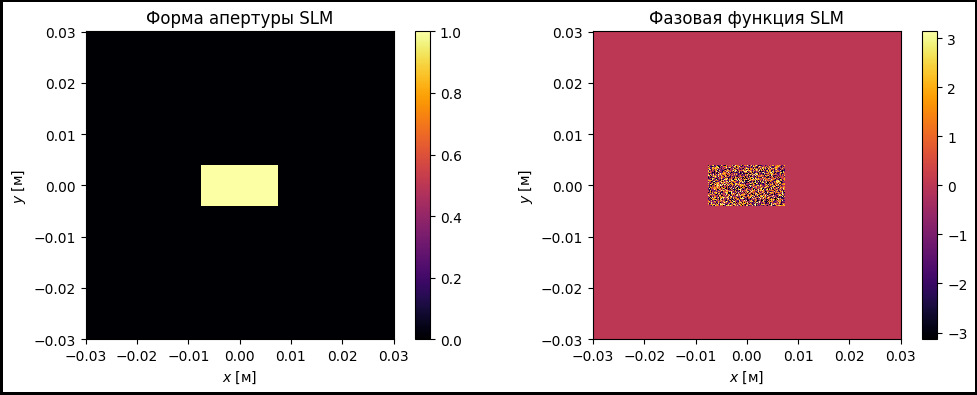

In [7]:
fig, ax = plt.subplots(
    1, 2, figsize=(12, 4), edgecolor='black', linewidth=3, frameon=True
)

im1 = ax[0].pcolormesh(x_grid, y_grid, slm_aperture, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'Форма апертуры SLM')
ax[0].set_xlabel('$x$ [м]')
ax[0].set_ylabel('$y$ [м]')
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(x_grid, y_grid, torch.real(torch.log(slm_transmission_function)/1j), cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Фазовая функция SLM')
ax[1].set_xlabel('$x$ [м]')
ax[1].set_ylabel('$y$ [м]')
fig.colorbar(im2, ax=ax[1])

plt.show()

In [8]:
field_after_slm = slm.forward(incident_wavefront=incident_wavefront)

phase_after_slm = field_after_slm.phase

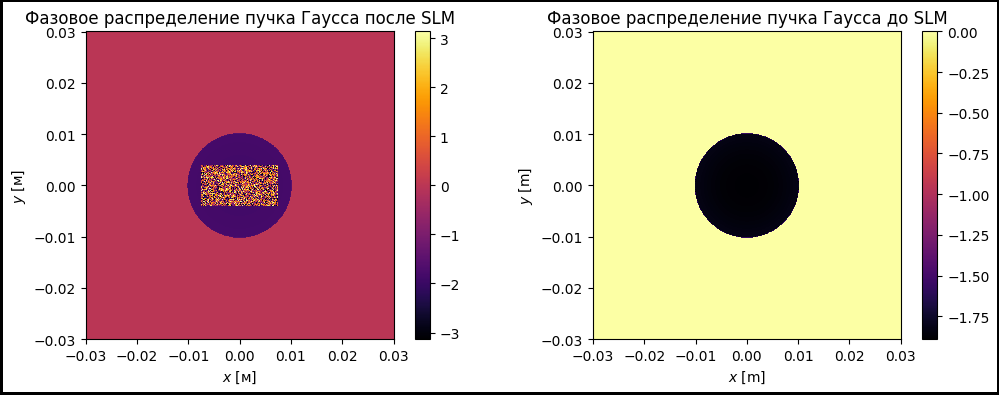

In [9]:
fig, ax = plt.subplots(
    1, 2, figsize=(12, 4), edgecolor='black', linewidth=3, frameon=True
)

im1 = ax[0].pcolormesh(x_grid, y_grid, phase_after_slm, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title("Фазовое распределение пучка Гаусса после SLM")
ax[0].set_xlabel('$x$ [м]')
ax[0].set_ylabel('$y$ [м]')
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(x_grid, y_grid, phase_before_slm, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title("Фазовое распределение пучка Гаусса до SLM")
ax[1].set_xlabel('$x$ [m]')
ax[1].set_ylabel('$y$ [m]')
fig.colorbar(im2, ax=ax[1])

plt.show()